# Making predictions with BlazeFace

This notebook shows how to use the model for face detection.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [2]:
import numpy as np
import torch
import cv2

In [3]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 1.11.0
CUDA version: 11.3
cuDNN version: 8200


In [4]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

## Load the model

In [5]:
from irislandmarks import IrisLandmarks

net = IrisLandmarks().to(gpu)
net.load_weights("irislandmarks.pth")

## Make a prediction

The input image should be 64x64. BlazeFace will not automatically resize the image, you have to do this yourself!

In [112]:
img = cv2.imread("test_eye.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (64, 64))

eye_gpu, iris_gpu = net.predict_on_image(img)
eye = eye_gpu.cpu().numpy()
iris = iris_gpu.cpu().numpy()
eye.shape
iris.shape

(1, 5, 3)

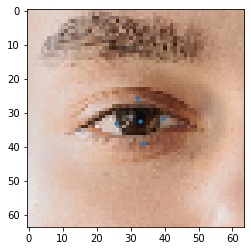

In [114]:
plt.imshow(img, zorder=1)
x, y = iris[0, :, 0], iris[0, :, 1] # 양 눈이면 iris가 두 개 있을 것. 
plt.scatter(x, y, zorder=2, s=10)
plt.show()

## 홍채

point 순서
<pre>
   2
3  0  1
   4
</pre>

In [167]:
# Mediapipe output
print(iris)

[[[34.152657  31.064833   4.1135893]
  [40.913315  29.774824   4.123985 ]
  [32.904987  24.563873   4.121566 ]
  [27.28487   32.296917   4.1190906]
  [35.47375   37.483856   4.15671  ]]]


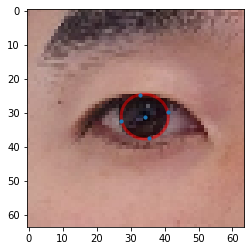

In [168]:
center = iris[0,0,:2]
x = iris[0,:,0]
y = iris[0,:,1]
ra = np.sqrt((x[1] - x[3])**2 + (y[1]-y[3])**2)/2
rb = np.sqrt((x[2] - x[4])**2 + (y[2]-y[4])**2)/2
angle = np.arctan((y[3] - y[1]) / (x[1] - x[3])) # note that y axis is flipped
angle = np.rad2deg(angle)

fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

ellipse = Ellipse(center, 2*ra,2*rb, angle=angle, alpha=0.5,
                  facecolor='none', edgecolor="red", lw=3)
x, y = iris[0, :, 0], iris[0, :, 1] # 양 눈이면 iris가 두 개 있을 것. 
plt.scatter(x, y, zorder=2, s=10)

ax.imshow(img)
ax.add_artist(ellipse)

plt.show()

In [169]:
print(center, ra, rb, angle)

[34.152657 31.064833] 6.929925258551381 6.586435028037627 10.484594


In [75]:
cap = cv2.VideoCapture("../data/test0/mobile_focus_30cm_FHD.mp4")
ret, frame = cap.read()

In [116]:
RGB_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

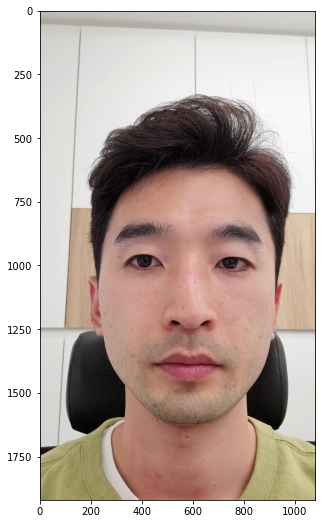

In [81]:
plt.figure(figsize = (16,9))
plt.imshow(RGB_img)

In [129]:
# crop

y_off=985
x_off=400
factor = 4
h=64*factor
w=64*factor
crop = RGB_img[y_off-int(h/2):y_off+int(h/2),
               x_off-int(w/2):x_off+int(w/2)]

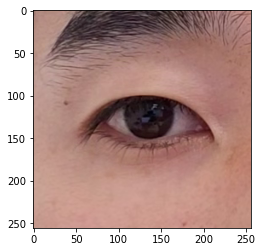

In [126]:
plt.imshow(crop)

In [127]:
img = cv2.resize(crop, (64, 64))
eye_gpu, iris_gpu = net.predict_on_image(img)

[[[34.152657  31.064833   4.1135893]
  [40.913315  29.774824   4.123985 ]
  [32.904987  24.563873   4.121566 ]
  [27.28487   32.296917   4.1190906]
  [35.47375   37.483856   4.15671  ]]]


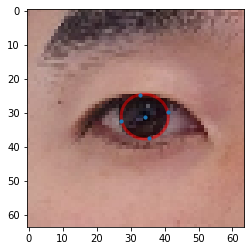

In [128]:
iris = iris_gpu.cpu().numpy()
print(iris)

x = iris[0,:,0]
y = iris[0,:,1]

center = iris[0,0,:2]
ra = np.sqrt((x[1] - x[3])**2 + (y[1]-y[3])**2)/2
rb = np.sqrt((x[2] - x[4])**2 + (y[2]-y[4])**2)/2
angle = np.arctan((y[3] - y[1]) / (x[1] - x[3])) # note that y axis is flipped
angle = np.rad2deg(angle)

from matplotlib.patches import Ellipse

fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})

ellipse = Ellipse(center, 2*ra,2*rb, angle=angle, alpha=0.5,
                  facecolor='none', edgecolor="red", lw=3)
x, y = iris[0, :, 0], iris[0, :, 1] # 양 눈이면 iris가 두 개 있을 것. 
plt.scatter(x, y, zorder=2, s=10)

ax.imshow(img)
ax.add_artist(ellipse)

plt.show()

In [151]:
ra_final = ra * factor
rb_final = rb * factor

shift = ((32,32) - center) * factor

center_final = (x_off, y_off) - shift#, center[0] * factor +x_off)

In [152]:
print(center_final, ra_final, rb_final, angle)

[408.61062622 981.25933075] 27.719701034205524 26.34574011215051 10.484594


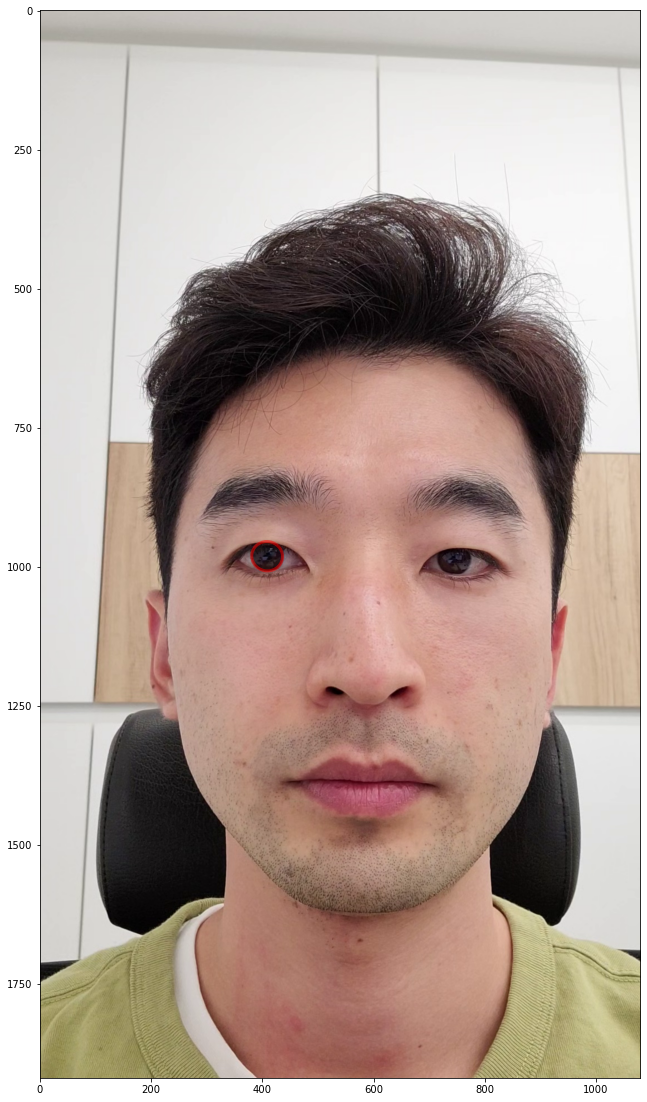

In [154]:
fig, ax = plt.subplots(subplot_kw={'aspect': 'equal'})
fig.set_size_inches(9,16)

ellipse = Ellipse(center_final, 
                  2*ra_final,
                  2*rb_final,
                  angle=angle, alpha=0.5,
                  facecolor='none', edgecolor="red", lw=3)

ax.imshow(RGB_img)
ax.add_artist(ellipse)
plt.tight_layout()
plt.savefig("../data/test.png")
#plt.show()

In [ ]:
cv2.cro

Let's convert model to ONNX format

In [10]:
torch.onnx.export(
    net, 
    (torch.randn(1,3,64,64, device='cpu'), ), 
    "irislandmarks.onnx",
    input_names=("image", ),
    output_names=("preds", "conf"),
    opset_version=9
)

/Users/george/Library/Mobile Documents/com~apple~CloudDocs/Projects/matt-research/snapchat_like/MediaPipe-PyTorch/facemesh.py:113: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  print(x.shape)


torch.Size([1, 3, 193, 193])
